<a href="https://colab.research.google.com/github/ribesstefano/chalmers_dat450_ml_for_nlp/blob/main/A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook could be found at this link: https://colab.research.google.com/drive/1f2nRQyfELRy0H8q0i5dFrVinJeuiTvz9?usp=sharing

Group N - Authors:

* Stefano Ribes
* -
* -

# Assignment 2: Topic Modeling

## Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('reuters')
nltk.download('brown')
from nltk.corpus import reuters, brown, stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder # optional
from scipy.special import gammaln

import spacy
nlp = spacy.load("en_core_web_sm")

le = LabelEncoder()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


## Corpus Download and Cleaning

In [2]:
def tokenize(text, lowercase=True):
    if lowercase:
        return [t.text.lower() for t in nlp.tokenizer(text)]
    else:
        return [t.text for t in nlp.tokenizer(text)]

In [3]:
def build_raw_df(corpus, n_files: int) -> pd.DataFrame:
    """Read raw text from corpus files and store in pandas DataFrame"""
    raw_text = []
    for file_id in corpus.fileids()[0:n_files]:
        raw_text.append(corpus.raw(file_id))
    return pd.DataFrame(raw_text, columns=['text'])


def process_corpus(df: pd.DataFrame, stop_words: set) -> list:
    """Remove capitalizations and stop-words from raw_df, store in long-format DataFrame"""
    token_doc_tups = []
    for document in df.text:
        tokens = tokenize(document.lower())
        tokens_clean = [t.lower() for t in tokens if t.lower() not in stop_words and t.isalpha()]
        token_doc_tups.append(tokens_clean)
    return token_doc_tups

In [31]:
# Load nltk stop-words
stop_words = set(stopwords.words('english'))
# Gen df with raw corpus
df_raw = build_raw_df(reuters, n_files=4000)
# df_raw = build_raw_df(brown, n_files=1000)
# Loop corpus to find uncommon words (less than 10 occurances)
corpus_freqs = Counter(t.lower() for x in df_raw['text'] for t in tokenize(x) if t.isalpha())
uncommon = set([word for (word, freq) in corpus_freqs.items() if freq < 10])
# Update stop_words to include uncommon words
stop_words.update(uncommon)
# Get list of documents
cleaned_corpus = process_corpus(df_raw, stop_words)
max_documents = 8000
cleaned_corpus = cleaned_corpus[:max_documents]

n_words = 0
for document in cleaned_corpus:
    n_words += len(document)
print(f'Number of words in (tokenized) corpus: {n_words}')

Number of words in (tokenized) corpus: 274494


In [69]:
for i in range(32):
    print(f'Document n.{i}: {" ".join(word for word in cleaned_corpus[i])}')

Document n.0: asian exporters fear damage mounting trade friction japan raised fears among many asia exporting nations row could far reaching economic damage businessmen officials said told reuter asian move japan might boost protectionist sentiment lead curbs american imports products exporters said conflict would hurt long run short term tokyo loss might gain said impose mln dlrs tariffs imports japanese electronics goods april retaliation japan alleged failure pact sell semiconductors world markets cost japanese estimates put impact tariffs billion dlrs major electronics firms said would virtually halt exports products hit new taxes would able business said spokesman leading japanese electronics firm electric industrial co ltd tariffs remain place time beyond months mean complete exports goods subject tariffs said stock analyst tokyo office broker co taiwan businessmen officials also worried aware threat japan serves warning us said senior trade official asked named taiwan trade tra

## NumBa Acceleration

We target two functions for acceleration:
* `initialiaze`: given a document, _i.e._ a matrix of (`n_docs`, `n_words`) containing the indexes of words in the vocabulary, populates the topic and count matrixes
* `sweep`: given the aforementioned topic and count matrixes, update conditional distribution, sample the new topics, and finally update the count matrixes. The `sweep` is called for each sample to be performed. 

In [32]:
from numba import jit, float32

@jit(cache=True)
def initialize(n_topics, n_docs, documents, topics, nmz, nzw, nz):
    for m in range(n_docs):
        # Retrieve vocab index for i-th word in document m.
        for w in documents[m]:
            # PAD tokens, assigned to -1, are skipped
            if w < 0:
                continue
            # Get random topic assignment, i.e. z = ...
            z = np.random.choice(n_topics) # Uniform distribution at init
            # Increment count matrices
            nmz[m, z] += 1
            nzw[z, w] += 1
            nz[z] += 1
            # Store topic assignment, i.e. topics[(m,i)]=z
            topics[m, w] = int(z)


@jit(cache=True)
def conditional(alpha, beta, nmz, nzw, nz, n_words, m, w):
    dist = (nmz[m, :] + alpha) * (nzw[:, w] + beta) / (nz + beta * n_words)
    return dist / np.sum(dist)


@jit(cache=True)
def sample_topic(n_topics, p):
    return np.random.choice(n_topics, p=p)


@jit(cache=True)
def sweep(alpha, beta, n_words, n_docs, n_topics, documents, topics, nmz, nzw, nz):
    for m in range(n_docs):
        # Retrieve vocab index for i-th word in document m.
        for w in documents[m]:
            # Skip PAD words, assigned to index -1
            if w < 0:
                continue
            # Retrieve topic assignment for i-th word in document m.
            z = topics[m, w]
            # Decrement count matrices.
            nmz[m, z] -= 1
            nzw[z, w] -= 1
            nz[z] -= 1
            # Get conditional distribution.
            p = conditional(alpha, beta, nmz, nzw, nz, n_words, m, w)
            # Sample new topic assignment.
            z = sample_topic(n_topics, p)
            # Increment count matrices.
            nmz[m, z] += 1
            nzw[z, w] += 1
            nz[z] += 1
            # Store new topic assignment.
            topics[m, w] = z

Once defined, the functions are compiled, cached, and tested with random data.

In [33]:
alpha = 0.1
beta = 0.01
n_docs = 3000
n_topics = 10
n_words = 2000
doc_max_len = 1000
documents = np.random.choice(n_words, size=(n_docs, doc_max_len)).astype(np.int32)
topics = np.zeros((n_docs, n_words)).astype(np.int32)
nmz = np.zeros((n_docs, n_topics)).astype(np.int32)
nzw = np.zeros((n_topics, n_words)).astype(np.int32)
nz = np.zeros((n_topics)).astype(np.int32)

initialize(n_topics, n_docs, documents, topics, nmz, nzw, nz)
sweep(alpha, beta, n_words, n_docs, n_topics, documents, topics, nmz, nzw, nz)
nmz

<ipython-input-32-7311f01f3dba>:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "sweep" failed type inference due to: Invalid use of type(CPUDispatcher(<function sample_topic at 0x7febb83d3170>)) with parameters (int64, array(float64, 1d, C))

During: resolving callee type: type(CPUDispatcher(<function sample_topic at 0x7febb83d3170>))
During: typing of call at <ipython-input-32-7311f01f3dba> (31)


File "<ipython-input-32-7311f01f3dba>", line 31:
def sweep(alpha, beta, n_words, n_docs, n_topics, documents, topics, nmz, nzw, nz):
    <source elided>
            # Sample new topic assignment.
            z = sample_topic(n_topics, p) # np.random.choice(n_topics, p=p)
            ^

  @jit(cache=True)
<ipython-input-32-7311f01f3dba>:14: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "sweep" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatch

array([[ 88, 105, 122, ...,  97,  97, 100],
       [ 97,  92,  94, ..., 118, 109, 100],
       [ 85, 111,  88, ...,  96,  94, 114],
       ...,
       [ 97, 107,  95, ..., 106, 122,  90],
       [ 89,  95,  85, ..., 106, 105,  90],
       [111,  98,  98, ...,  84,  98, 103]], dtype=int32)

## LDA With Collapsed Gibbs Sampling

In [109]:
class LDACGS:
    """Do LDA with Collapsed Gibbs Sampling."""
    def __init__(self, n_topics=2, alpha=0.1, beta=0.01):
        """Initialize system parameters."""
        self.n_topics = n_topics
        self.alpha = alpha
        self.beta = beta
        self.corpus_built = False

    def buildCorpus(self, doclines=None, filename=None, stopwords_file=None):
        """Read the given filename and build the vocabulary."""
        if doclines:
            if type(doclines[0] == list):
                doclines = [' '.join(w for w in line).rstrip('.,\n').lower().split(' ') for line in doclines]
            else:
                doclines = [line.rstrip('.,\n').lower().split(' ') for line in doclines]
        elif filename:
            with open(filename, 'r') as infile:
                doclines = [line.rstrip('.,\n').lower().split(' ') for line in infile]
        elif not filename and not doclines:
            raise ValueError('Either filename or doclines must be supplied.')
        self.doclines = doclines
        n_docs = len(doclines)
        self.vocab = list({v for doc in doclines for v in doc})
        # NOTE: We are assuming that the stop words have already been removed.
        if stopwords_file:
            with open(stopwords_file, 'r') as stopfile:
                stops = stopfile.read().split()
            self.vocab = [x for x in self.vocab if x not in stops]
            self.vocab.sort()
        self.documents = []
        self.doc_max_len = 0
        for i in range(n_docs):
            self.documents.append({})
            for j in range(len(doclines[i])):
                if doclines[i][j] in self.vocab:
                    self.documents[i][j] = self.vocab.index(doclines[i][j])
            if len(self.documents[i]) > self.doc_max_len:
                self.doc_max_len = len(self.documents[i])
        print(f'INFO. Vocabulary size: {len(self.vocab)}')
        print(f'INFO. Number of documents in corpus: {len(self.documents)}')
        self.corpus_built = True

    def initialize(self, n_topics=None):
        """Initialize the three count matrices."""
        if n_topics:
            self.n_topics = n_topics    
        self.n_words = len(self.vocab)
        self.n_docs = len(self.documents)
        # ======================================================================
        # Convert list of dictionaries to pure numpy arrays
        # ======================================================================
        # NOTE: Init PAD tokens to -1
        self.documents_np = -np.ones((self.n_docs, self.doc_max_len),
                                     dtype=np.int32)
        for i in range(self.n_docs):
            vals = list(self.documents[i].values())
            for j in range(self.doc_max_len):
                if j < len(vals):
                    self.documents_np[i][j] = int(vals[j])
        # ======================================================================
        # Instantiate the three count matrices.
        # ======================================================================
        # The (i,j) entry of self.nmz is the number of words in document i
        # assigned to topic j.
        self.nmz = np.zeros((self.n_docs, self.n_topics), dtype=np.int32)
        # The (i,j) entry of self.nzw is the number of times term j is
        # assigned to topic i.
        self.nzw = np.zeros((self.n_topics, self.n_words), dtype=np.int32)
        # The (i)-th entry is the number of times topic i is assigned in the
        # corpus.
        self.nz = np.zeros(self.n_topics, dtype=np.int32)
        # Initialize the topic assignment dictionary.
        self.topics = {} # key-value pairs of form (m,i):z
        self.topics_np = -np.ones((self.n_docs, self.n_words), dtype=np.int32)
        # ======================================================================
        # Initialize the topics and the three count matrices.
        # ======================================================================
        initialize(self.n_topics, self.n_docs, self.documents_np,
                   self.topics_np, self.nmz, self.nzw, self.nz)

    def sample(self, doclines=None, filename=None, burnin=100, sample_rate=10,
               n_samples=10, stopwords=None, n_topics=None, alpha=None,
               beta=None, verbose=0):
        if alpha:
            self.alpha = alpha
        if beta:
            self.beta = beta
        if not self.corpus_built:
            if verbose:
                print(f'INFO. Building corpus.')
            self.buildCorpus(doclines, filename, stopwords)
        if verbose:
            print(f'INFO. Corpus built. Initializing.')
        self.initialize(n_topics)
        self.total_nzw = np.zeros((self.n_topics, self.n_words))
        self.total_nmz = np.zeros((self.n_docs, self.n_topics))
        self.logprobs = np.zeros(burnin + sample_rate * n_samples)
        if verbose:
            print(f'INFO. Starting Burn-in sampling.')
        for i in tqdm(range(burnin)):
            # Sweep and store log likelihood.
            sweep(self.alpha, self.beta, self.n_words, self.n_docs,
                  self.n_topics, self.documents_np, self.topics_np, self.nmz,
                  self.nzw, self.nz)
            self.logprobs[i] = self._loglikelihood()
        if verbose:
            print(f'INFO. Burn-in sampling complete.')
        for i in tqdm(range(n_samples * sample_rate)):
            # Sweep and store log likelihood
            sweep(self.alpha, self.beta, self.n_words, self.n_docs,
                  self.n_topics, self.documents_np, self.topics_np, self.nmz,
                  self.nzw, self.nz)
            self.logprobs[burnin + i] = self._loglikelihood()
            if not i % sample_rate:
                # Accumulate counts
                self.total_nzw += self.nzw
                self.total_nmz += self.nmz
            else:
                if verbose:
                    print(f'INFO. Sampling n.{burnin + i} complete.')

    def phi(self):
        phi = self.total_nzw + self.beta
        self._phi = phi / (np.sum(phi, axis=1)[:, np.newaxis] + self.beta * self.n_words)

    def theta(self):
        theta = self.total_nmz + self.alpha
        self._theta = theta / (np.sum(theta, axis=1)[:, np.newaxis] + self.alpha + self.n_topics)

    def topterms(self, n_terms=10):
        self.phi()
        self.theta()
        vec = np.atleast_2d(np.arange(0, self.n_words))
        topics = []
        for k in range(self.n_topics):
            probs = np.atleast_2d(self._phi[k, :])
            mat = np.append(probs, vec, 0)
            sind = np.array([mat[:, i] for i in np.argsort(mat[0])]).T
            topics.append([self.vocab[int(sind[1, self.n_words - 1 - i])] for i in range(n_terms)])
        return topics

    def toplines(self, n_lines=5, convert=True):
        lines = np.zeros((self.n_topics, n_lines), dtype=np.int32)
        for i in range(self.n_topics):
            args = np.argsort(self._theta[:, i]).tolist()
            args.reverse()
            lines[i, :] = np.array(args)[0:n_lines] + 1
        if convert:
            ret = []
            for line in lines:
                ret.append([self.doclines[d] for d in line])
            lines = ret
        return lines

    def _removeStopwords(self, stopwords):
        return [x for x in self.vocab if x not in stopwords]

    def _conditional(self, m, w):
        dist = (self.nmz[m, :] + self.alpha) * (self.nzw[:, w] + self.beta) / (self.nz + self.beta * self.n_words)
        return dist / np.sum(dist)

    def _loglikelihood(self):
        lik = 0
        for z in range(self.n_topics):
            lik += np.sum(gammaln(self.nzw[z,:] + self.beta)) - gammaln(np.sum(self.nzw[z,:] + self.beta))
            lik -= self.n_words * gammaln(self.beta) - gammaln(self.n_words * self.beta)
        for m in range(self.n_docs):
            lik += np.sum(gammaln(self.nmz[m,:] + self.alpha)) - gammaln(np.sum(self.nmz[m,:] + self.alpha))
            lik -= self.n_topics * gammaln(self.alpha) - gammaln(self.n_topics * self.alpha)
        return lik

In [108]:
ldacgs = LDACGS()
ldacgs.buildCorpus(cleaned_corpus)

INFO. Vocabulary size: 3643
INFO. Number of documents in corpus: 4000


In [70]:
n_topics = 50 # 10 or 50
burnin = 100 # 100 or 200
ldacgs.sample(burnin=burnin, sample_rate=1, n_samples=1, n_topics=n_topics, verbose=0)

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


In [78]:
n_topics = 10 # 10 or 50
burnin = 100 # 100 or 200
ldacgs.sample(burnin=burnin, sample_rate=1, n_samples=1, n_topics=n_topics, verbose=0)

100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


In [79]:
topics = ldacgs.topterms(n_terms=20)
for i, topic in enumerate(topics):
    print(f'Topic n.{i}: {", ".join(t for t in topic)}')

Topic n.0: said, mln, vs, dlrs, pct, net, cts, billion, year, shr, inc, would, company, loss, corp, oil, market, last, qtr, share
Topic n.1: said, mln, vs, dlrs, cts, pct, net, billion, year, loss, shr, would, company, inc, share, trade, corp, qtr, shares, bank
Topic n.2: said, mln, vs, dlrs, pct, cts, net, year, billion, company, shr, loss, would, inc, trade, qtr, corp, oil, market, shares
Topic n.3: said, mln, vs, dlrs, cts, pct, net, year, billion, shr, would, inc, company, loss, corp, last, trade, oil, share, qtr
Topic n.4: said, mln, vs, dlrs, pct, net, cts, year, billion, would, shr, company, loss, inc, corp, oil, trade, share, profit, qtr
Topic n.5: said, mln, vs, dlrs, cts, pct, net, year, billion, company, would, shr, inc, bank, loss, qtr, corp, last, trade, share
Topic n.6: said, mln, vs, dlrs, pct, cts, net, year, billion, company, would, shr, loss, inc, corp, oil, bank, last, share, trade
Topic n.7: said, mln, vs, dlrs, pct, cts, net, year, billion, shr, would, loss, compan

In [85]:
lines = ldacgs.toplines(n_lines=5)
for i, l in enumerate(lines):
    print(f'Line n.{i}:')
    for d in l:
        print(f"{str(' '.join([w for w in d]))}")
    print('')

Line n.0:
gte corp qtr net shr cts vs cts net mln vs mln revs billion vs billion nine mths shr dlrs vs dlrs net mln vs mln revs billion vs billion note share results restated stock split january net periods includes business gains mln dlrs five cts share gains early retirement programs mln dlrs cts share nine months net also includes pre tax charge mln dlrs gte share special write sprint reduced tax net mln dlrs cts share net periods includes business gains mln dlrs cts per share
eastern utilities associates ups payout qtly div cts vs cts prior qtr pay may record may
inc qtr oper oper shr dlrs vs cts oper net mln vs mln revs mln vs mln nine mths oper shr dlrs vs dlrs oper net mln vs mln revs mln vs mln note qtr nine mths oper net excludes gains tax loss carryforwards dlrs dlrs respectively qtr nine mths oper net excludes tax carryforward gains dlrs dlrs respectively
bell group standard chartered stake bell group ltd said holds pct issued capital standard chartered plc acquiring shares 

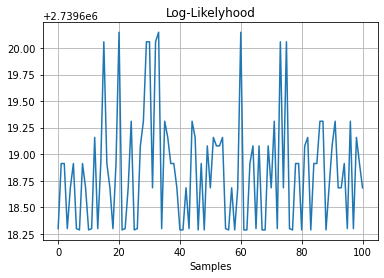

In [87]:
import matplotlib.pyplot as plt

plt.plot(-ldacgs.logprobs, label='LogLikelyhood')
plt.title('Negative Log-Likelyhood')
plt.xlabel('Samples')
plt.grid('both')
plt.show()

## $U_{MASS}$ Coherence Score

In [100]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

In [103]:
cm = CoherenceModel(topics=topics,
                    dictionary=Dictionary(ldacgs.doclines),
                    texts=ldacgs.doclines,
                    topn=20,
                    coherence='u_mass')
coherence = cm.get_coherence()
# NOTE: uMass is: -14 < x < 14
print(f'Umass coherence score: {coherence:.3f}')

Umass coherence score: -1.941


## Evaluation

In [110]:
ldacgs = LDACGS()
ldacgs.buildCorpus(cleaned_corpus)

INFO. Vocabulary size: 3643
INFO. Number of documents in corpus: 4000


In [111]:
dictionary = Dictionary(ldacgs.doclines)

for K in [10, 20, 50]:
    for burnin in [100, 200]:
        for alpha, beta in [(0.1, 0.1), (0.1, 0.01)]:
            # Perform Gibbs sampling
            ldacgs.sample(burnin=burnin, sample_rate=1, n_samples=1, n_topics=K,
                          alpha=alpha, beta=beta)
            # Get topics
            topics = ldacgs.topterms(n_terms=20)
            # Calculate U-mass coherency score
            cm = CoherenceModel(topics=topics,
                                dictionary=dictionary,
                                texts=ldacgs.doclines,
                                topn=20,
                                coherence='u_mass')
            coherence = cm.get_coherence()
            # NOTE: uMass is: -14 < x < 14
            print(f'Umass coherence score for {K} topics and brun-in {burnin} (α={alpha}, β={beta}): {coherence:.3f}')

100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


Umass coherence score for 10 topics and brun-in 100 (α=0.1, β=0.1): -1.882


100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


Umass coherence score for 10 topics and brun-in 100 (α=0.1, β=0.01): -1.931


100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


Umass coherence score for 10 topics and brun-in 200 (α=0.1, β=0.1): -1.888


100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


Umass coherence score for 10 topics and brun-in 200 (α=0.1, β=0.01): -1.913


100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


Umass coherence score for 20 topics and brun-in 100 (α=0.1, β=0.1): -1.920


100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


Umass coherence score for 20 topics and brun-in 100 (α=0.1, β=0.01): -1.930


100%|██████████| 1/1 [00:00<00:00,  7.07it/s]


Umass coherence score for 20 topics and brun-in 200 (α=0.1, β=0.1): -1.924


100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


Umass coherence score for 20 topics and brun-in 200 (α=0.1, β=0.01): -1.914


100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


Umass coherence score for 50 topics and brun-in 100 (α=0.1, β=0.1): -2.000


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


Umass coherence score for 50 topics and brun-in 100 (α=0.1, β=0.01): -1.973


100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


Umass coherence score for 50 topics and brun-in 200 (α=0.1, β=0.1): -2.001


100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


Umass coherence score for 50 topics and brun-in 200 (α=0.1, β=0.01): -1.963
